# Reinforcement Learning (DQN) tutorial

- http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

- OpenAI GymのCatPole task
- 環境の状態は (position, velocity, ...) など4つの数値が与えられるが
- DQNではカートを中心とした画像を入力とする
- 厳密に言うと状態＝現在の画像と1つ前の画像の差分

> Strictly speaking, we will present the state as the difference between the current screen patch and the previous one. This will allow the agent to take the velocity of the pole into account from one image.

TODO: DQNではなく、4つの数値を状態としたQ-Learningで学習

- OpenAI Gymを使うので `pip install gym` でインストール

In [6]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

%matplotlib inline

In [7]:
# setup matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [8]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [9]:
env = gym.make('CartPole-v0').unwrapped
env

[2018-02-12 21:14:26,061] Making new env: CartPole-v0


## Experience Replay

- DQNは観測を蓄積しておいてあとでシャッフルしてサンプリングして使う

> Transition - a named tuple representing a single transition in our environment
ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [10]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [11]:
# namedtupleの使い方
t = Transition(1, 2, 3, 4)
print(t)
print(t.state, t.action, t.next_state, t.reward)

Transition(state=1, action=2, next_state=3, reward=4)
1 2 3 4


In [12]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        """Save a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        # memoryを使い切ったら古いのから上書きしていく
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [13]:
# ReplayMemoryの動作確認
rm = ReplayMemory(3)
rm.push(1, 1, 1, 1)
rm.push(2, 2, 2, 2)
rm.push(3, 3, 3, 3)
print(len(rm))
print(rm.memory)
rm.push(4, 4, 4, 4)
print(len(rm))
print(rm.memory)

3
[Transition(state=1, action=1, next_state=1, reward=1), Transition(state=2, action=2, next_state=2, reward=2), Transition(state=3, action=3, next_state=3, reward=3)]
3
[Transition(state=4, action=4, next_state=4, reward=4), Transition(state=2, action=2, next_state=2, reward=2), Transition(state=3, action=3, next_state=3, reward=3)]


In [62]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [63]:
dqn = DQN()
dqn

DQN(
  (conv1): Conv2d (3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (head): Linear(in_features=448, out_features=2)
)

In [64]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize((40, 40), interpolation=Image.CUBIC),
                    T.ToTensor()])

- https://github.com/openai/gym/wiki/CartPole-v0
- state[0] = Cart Position (-2.4, 2.4)
- env.x_threshold = 2.4

In [31]:
screen_width = 600

def get_cart_location():
    """台車の位置をピクセル単位で返す"""
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

- Jupyter Notebook上だとrender()が動かない！
- `NotImplementedError: abstract`

In [55]:
def get_screen():
    """ゲーム画面を取得する"""
    # env.reset() しておかないとrenderはNoneが変えるので注意
    # PyTorchの (C, H, W) の順に変換する
    # default: (3, 800, 1200)
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))

    # 台車を中心として 320 x 640 の範囲を切り出す
    # 画面の上下の部分を除く（台車のある範囲のみ残す）
    screen = screen[:, 320:640]

    # 横幅は台車を中心としてこの範囲を切り出す
    view_width = 640
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        # view_widthの範囲を切り出すと左が画面からはみ出る場合
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        # view_widthの範囲を切り出すと右が画面からはみ出る場合
        slice_range = slice(-view_width, None)
    else:
        # 両端が画面からはみ出ない場合
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    screen = screen[:, :, slice_range]

    # TODO: ascontiguousarray()は高速化のため？
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255

    # Tensorに変換
    screen = torch.from_numpy(screen)

    # リサイズしてバッチ数の次元を4Dテンソルにして返す
    return resize(screen).unsqueeze(0).type(Tensor)

In [56]:
get_screen()

NotImplementedError: abstract

- ゲーム画面取得や描画関連のコードはコンソール上で実行すること！

In [ ]:
env.reset()
patch = get_screen()
print(patch.size())  # torch.Size([1, 3, 40, 40])

In [ ]:
# 切り取ったゲーム画面を描画
env.reset()
plt.figure()
# get_screen()は4Dテンソルで返ってくるので描画できるようにndarrayに戻す
patch = get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(patch, interpolation='none')
plt.title('Example extracted screen')
plt.show()

## 訓練コード

In [81]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9   # 探査率の開始値
EPS_END = 0.05    # 探査率の終了値
EPS_DECAY = 200   # 値が小さいほど低下が急激

In [65]:
model = DQN()

if use_cuda:
    model.cuda()

optimizer = optim.RMSprop(model.parameters())
memory = ReplayMemory(10000)

steps_done = 0

In [66]:
model

DQN(
  (conv1): Conv2d (3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (head): Linear(in_features=448, out_features=2)
)

- 探査率は学習が進むにつれて徐々に減らすスケジューリングをしている
- 探査率の変化曲線を描画してみる

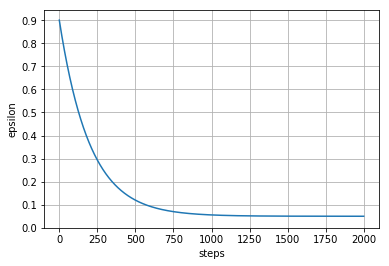

In [83]:
# 探査率のスケジューリング
eps_list = []
for steps_done in range(2000):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    eps_list.append(eps_threshold)
plt.plot(range(2000), eps_list)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xlabel('steps')
plt.ylabel('epsilon')
plt.grid()